In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
! pip install statsmodels==0.12.1
import statsmodels
assert statsmodels.__version__ == '0.12.1'

In [ ]:
data = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

In [ ]:
pd.read_csv(data)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [ ]:
df = pd.read_csv(data, usecols=['Date', 'Temp'], index_col='Date', parse_dates=True)

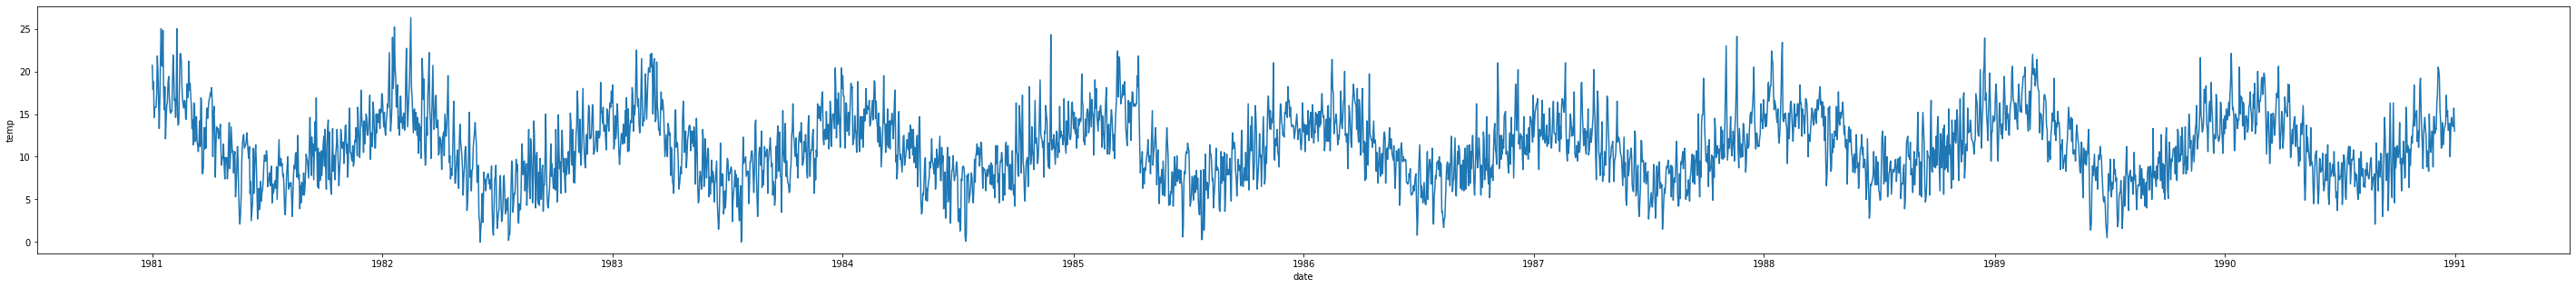

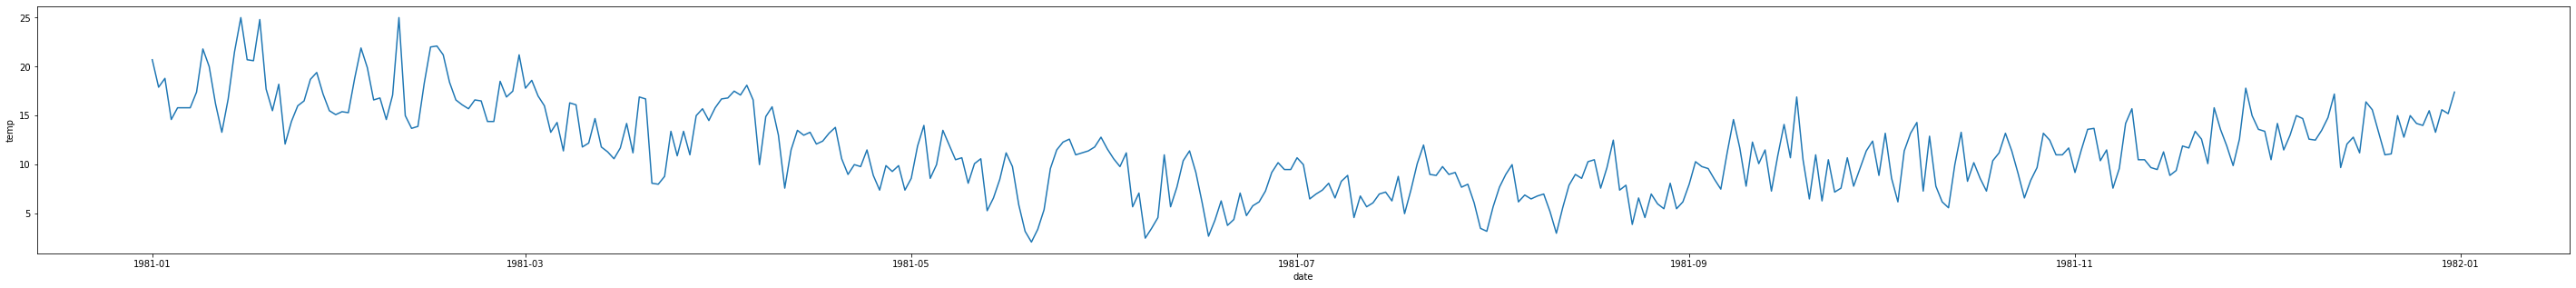

In [ ]:
plt.figure(figsize=(50,5))
plt.plot(df)
plt.xlabel('date')
plt.ylabel('temp')
plt.show()

plt.figure(figsize=(50,5))
#plt.plot(df['01-01-1981':'01-01-1982'])
plt.plot(df['1981'])
plt.xlabel('date')
plt.ylabel('temp')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

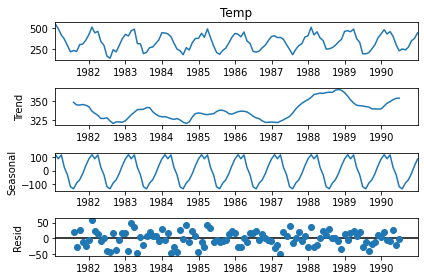

In [ ]:
resampled = df.resample('m').sum()['Temp']    # change the resample y/m/d/

fig = seasonal_decompose(resampled).plot()

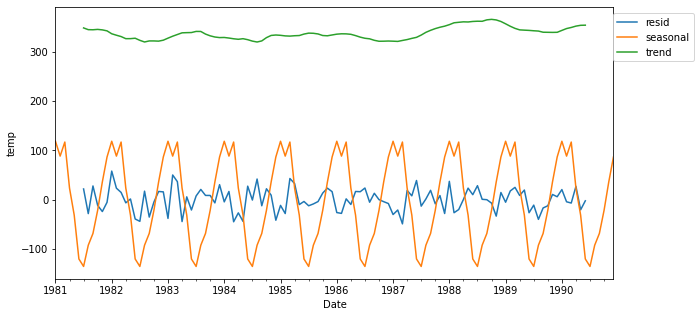

In [ ]:
decopose = seasonal_decompose(resampled)
plt.figure(figsize=(50,5))
decopose.resid.plot(label="resid")
decopose.seasonal.plot(label="seasonal")
decopose.trend.plot(label="trend")
plt.legend(loc=(1,0.8))
plt.ylabel("temp")
plt.show()

We can see that the trend is constant so the series is s

Dickey-Fuller Hypothesis testing:
> This hypothesis checks if the series is stationary or not
> 
> Null Hypothesis: The searies is not stationary
>
> Alternate Hypothesis: The searies is stationary

Code stipped from https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f

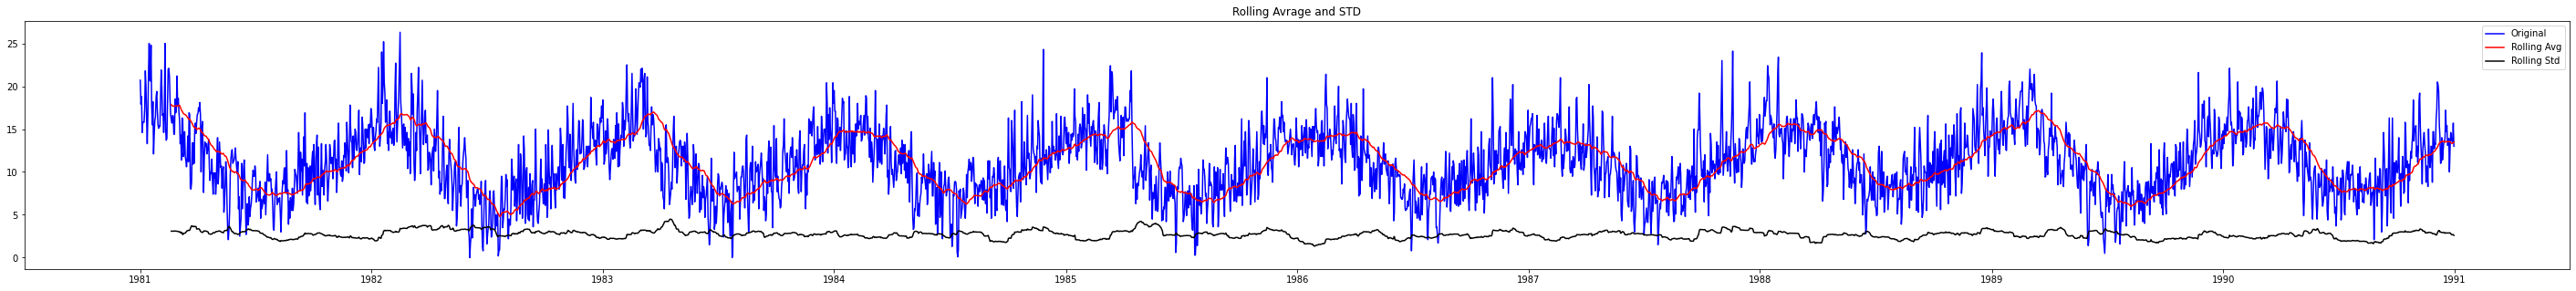

Test statistic                    -4.444805
p-value                            0.000247
#Lags used                        20.000000
#Number of Observations Used    3629.000000
Critical value 1%                 -3.432153
Critical value 5%                 -2.862337
Critical value 10%                -2.567194
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

rolmeans = df.rolling(window=50, center=False).mean()
rolstd = df.rolling(window=50, center=False).std()

dftest = adfuller(df['Temp'])

plt.figure(figsize=(50,5))
plt.plot(df, color='blue', label='Original')
plt.plot(rolmeans, color='red', label='Rolling Avg')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Avrage and STD')
plt.show(block=False)

dfoutput = pd.Series(dftest[0:4], index=['Test statistic', 'p-value', 
                                         '#Lags used', 
                                         '#Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical value {key}'] = value
print(dfoutput)


p-value is less then 0.05 so we will reject the null hypothesis -> The searies is stationary

In [ ]:
(df.index[1:] - df.index[:-1]) # getting the time spaces

TimedeltaIndex(['1 days', '1 days', '1 days', '1 days', '1 days', '1 days',
                '1 days', '1 days', '1 days', '1 days',
                ...
                '1 days', '1 days', '1 days', '1 days', '1 days', '1 days',
                '1 days', '1 days', '1 days', '1 days'],
               dtype='timedelta64[ns]', name='Date', length=3649, freq=None)

Split for prediction

In [ ]:
ratio = 0.05   #  test set is 5%
train = df[:int(df.shape[0]*(1-ratio))]['Temp']
test = df[int(df.shape[0]*(1-ratio)):]['Temp']

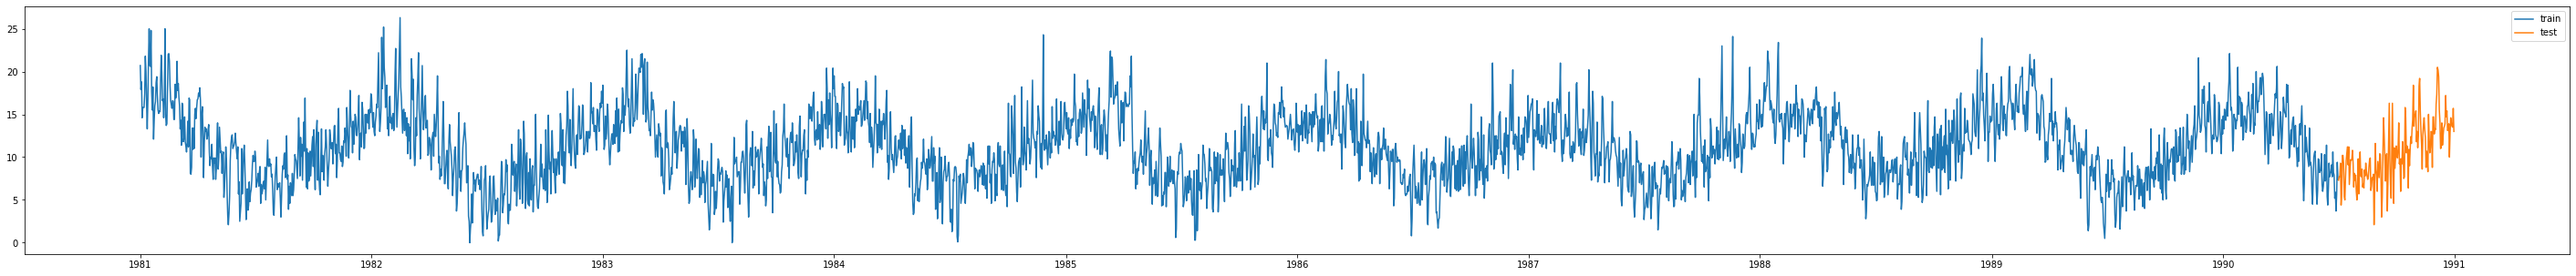

In [ ]:
plt.figure(figsize=(50,5))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.show()

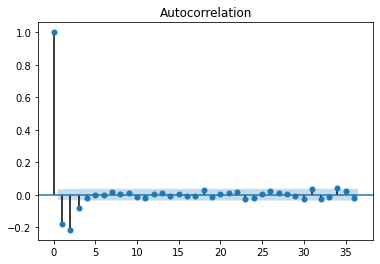

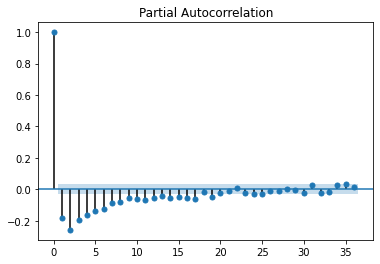

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train.diff(periods=1).dropna())
plot_pacf(train.diff(periods=1).dropna());

From ACF -> MA(4)

From PACF -> AR(17)

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm
history = train.to_list()
predictions = []

for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(2,1,1))    # order=(4,1,17)
    model_fit = model.fit()
    predict = model_fit.forecast()[0]
    history.append(test[t])
    predictions.append(predict)




  0%|          | 0/183 [00:00<?, ?it/s]

  1%|          | 1/183 [00:00<01:42,  1.77it/s]

  1%|          | 2/183 [00:01<01:38,  1.83it/s]

  2%|▏         | 3/183 [00:01<01:36,  1.87it/s]

  2%|▏         | 4/183 [00:02<01:34,  1.90it/s]

  3%|▎         | 5/183 [00:02<01:34,  1.88it/s]

  3%|▎         | 6/183 [00:03<01:32,  1.92it/s]

  4%|▍         | 7/183 [00:03<01:32,  1.91it/s]

  4%|▍         | 8/183 [00:04<01:30,  1.93it/s]

  5%|▍         | 9/183 [00:04<01:29,  1.94it/s]

  5%|▌         | 10/183 [00:05<01:28,  1.95it/s]

  6%|▌         | 11/183 [00:05<01:28,  1.95it/s]

  7%|▋         | 12/183 [00:06<01:28,  1.94it/s]

  7%|▋         | 13/183 [00:06<01:28,  1.93it/s]

  8%|▊         | 14/183 [00:07<01:32,  1.82it/s]

  8%|▊         | 15/183 [00:07<01:33,  1.79it/s]

  9%|▊         | 16/183 [00:08<01:35,  1.75it/s]

  9%|▉         | 17/183 [00:09<01:31,  1.82it/s]

 10%|▉         | 18/183 [00:09<01:29,  1.85it/s]

 10%|█         | 19/183 [00:10<01:28,  1.86it/s]

 11%|█         |

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3649
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -8384.279
Date:                Sun, 17 Jan 2021   AIC                          16776.558
Time:                        15:42:18   BIC                          16801.366
Sample:                             0   HQIC                         16785.393
                               - 3649                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4965      0.017     28.566      0.000       0.462       0.531
ar.L2         -0.1296      0.018     -7.398      0.000      -0.164      -0.095
ma.L1         -0.9008      0.010    -92.094      0.000      -0.920      -0.882
sigma2         5.8035      0.128     45.184      0.000       5.552       6.055
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

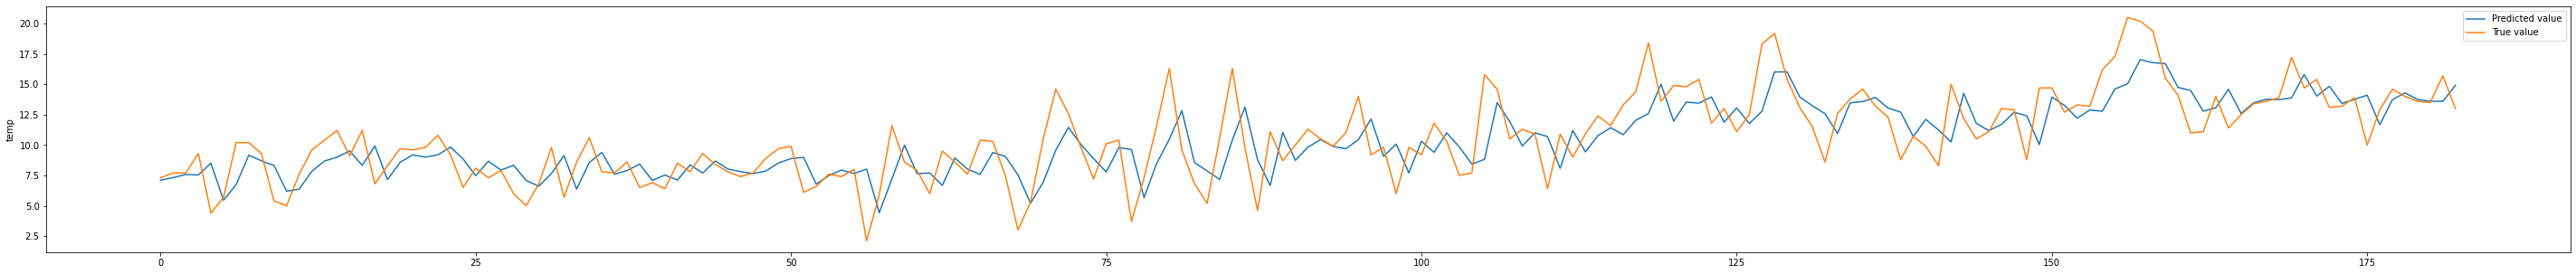

RMSE: 31.99947158532305


In [ ]:
plt.figure(figsize=(50,5))
plt.plot(predictions, label='Predicted value')
plt.plot(test.values, label='True value')
plt.ylabel('temp')
plt.legend()
plt.xlim()
plt.show()

RMSE = np.sqrt(((np.array(predictions) - test.values)**2).sum())
print(f'RMSE: {RMSE}')

predict next 10 days

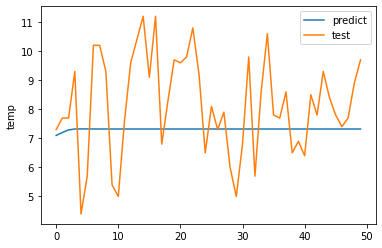

In [ ]:
n=50  # number of days to predict
model = ARIMA(train.values, order=(2,1,1))
model_fit = model.fit()
plt.plot(model_fit.forecast(n), label='predict')
plt.plot(test[:n].values, label='test')
plt.ylabel('temp')
plt.legend()
plt.show()

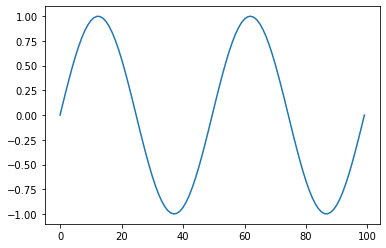

In [ ]:
X = np.linspace(-2*np.pi, 2*np.pi,100)
y = np.sin(X)
plt.plot(y);

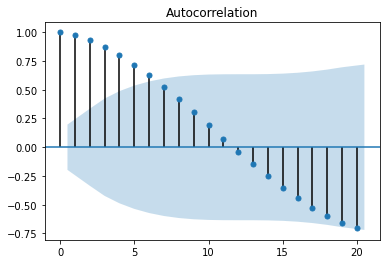

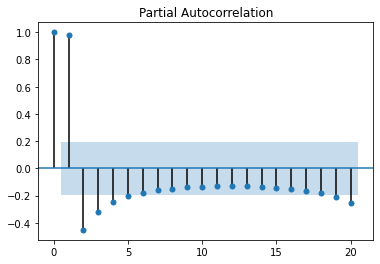

In [ ]:
diff = y[:-1] - y[1:]

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff)
plot_pacf(diff);

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:12,  1.52it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 10%|█         | 2/20 [00:01<00:13,  1.32it/s]

 15%|█▌        | 3/20 [00:02<00:14,  1.16it/s]

 20%|██        | 4/20 [00:03<00:13,  1.21it/s]

 25%|██▌       | 5/20 [00:04<00:11,  1.30it/s]

 30%|███       | 6/20 [00:04<00:10,  1.32it/s]

 35%|███▌      | 7/20 [00:05<00:11,  1.17it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found.

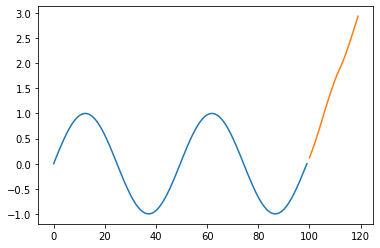

In [ ]:
predictions = []
history = y.tolist()

n = 20
for t in tqdm(range(n)):
    model = SARIMAX(history, order=(1,0,0), seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    predict = model_fit.forecast()[0]
    history.append(predict)
    predictions.append(predict)


plt.plot(y)
plt.plot(np.arange(len(y), len(y)+n), np.array(predictions))

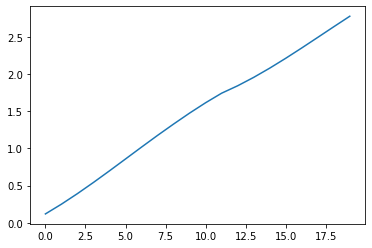

In [ ]:
model = SARIMAX(y.tolist(), order=(1,0,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()

plt.plot(model_fit.forecast(n))

In [ ]:
model_fit.forecast(n) - np.array(predictions)

array([ 0.        , -0.00287359, -0.00531328, -0.0097442 , -0.01560575,
       -0.0233268 , -0.03245653, -0.0407645 , -0.04485146, -0.04841248,
       -0.05255514, -0.0559645 , -0.05964131, -0.06818775, -0.07542074,
       -0.08631855, -0.09988584, -0.11730431, -0.13688206, -0.15508417])